In [2]:
import pandas as pd
import datetime
import os
from pprint import pprint
from dotted_dict import DottedDict as dotdict
import matplotlib.pyplot as plt
import math

pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', 20) 

plt.style.use('classic')
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['axes.formatter.limits'] = [-1000000000, 1000000000]

### Analyse Backtests

In [3]:
bt_output_base_path = "/mnt/c/trading/backtest/output"

bt_name = "some_bt"
instrument = "MES"

base_path = f"{bt_output_base_path}/{bt_name}/{instrument}"
print(base_path)

run_names = os.listdir(base_path)
run_names

/mnt/c/trading/backtest/output/some_bt/MES


['run_202409251200_202409252100',
 'run_202409261200_202409262100',
 'run_202409271200_202409272100',
 'run_202409301200_202409302100',
 'run_202410011200_202410012100',
 'run_202410021200_202410022100',
 'run_202410031200_202410032100',
 'run_202410041000_202410042100']

In [4]:
default_files = ['trades.csv', 'trades_f2f.csv', 'trade_statistics.csv']

def make_bt():
    bt = {"runs": [{} for _ in range(len(run_names))]}
    for idx, run_name in enumerate(run_names):
        print(f"processing bt run -> {run_name}")
        current_run_path = f"{base_path}/{run_name}"
        files = os.listdir(current_run_path)
        
        bt["runs"][idx] = {}
        start, end = run_name.split('_')[1:]
        bt["runs"][idx]["range"] = {
            "start": datetime.datetime.strptime(start, '%Y%m%d%H%M%S'),
            "end": datetime.datetime.strptime(end, '%Y%m%d%H%M%S')
        }
        
        for fname in default_files:
            bt["runs"][idx][fname.split('.')[0]] = pd.read_csv(f"{current_run_path}/{fname}")
    
        bt["runs"][idx]["subgraphs"] = {}
        bt["runs"][idx]["vectors"] = {}
        for fname in [fn for fn in files if fn not in default_files]:
            name = fname.split(".")[0]
            try:
                if name.startswith('sg_'):
                    bt["runs"][idx]["subgraphs"][name.replace("sg_", "")] = pd.read_csv(f"{current_run_path}/{fname}")
                elif name.startswith("v_"):
                    bt["runs"][idx]["vectors"][name.replace("v_", "")] = pd.read_csv(f"{current_run_path}/{fname}")
                elif name == "persistent_values.csv":
                    bt["runs"][idx]["persistent_values"] = pd.read_csv(f"{current_run_path}/persistent_values.csv")
            except Exception as e:
                print(e)
                continue
            
        print("-"*25)

    print('done.')
    bt = dotdict(bt)
    return bt

processing bt run -> run_202409251200_202409252100
-------------------------
processing bt run -> run_202409261200_202409262100
-------------------------
processing bt run -> run_202409271200_202409272100
-------------------------
processing bt run -> run_202409301200_202409302100
-------------------------
processing bt run -> run_202410011200_202410012100
-------------------------
processing bt run -> run_202410021200_202410022100
-------------------------
processing bt run -> run_202410031200_202410032100
-------------------------
processing bt run -> run_202410041000_202410042100
-------------------------
done.
[run = 0] (2024-09-25 12:00:00, 2024-09-25 21:00:00) account_value: 25000 -> 24950


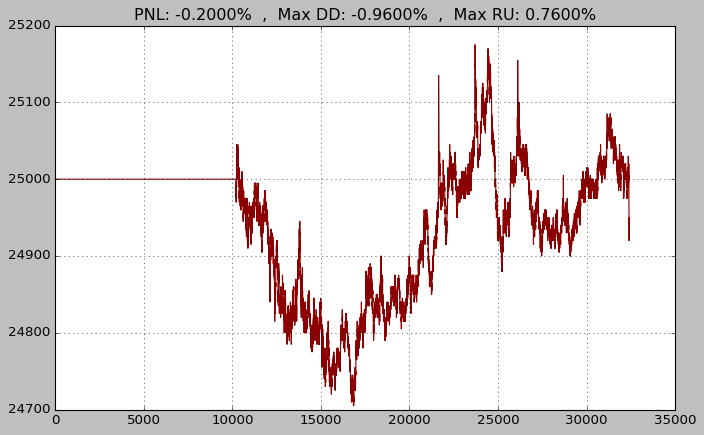

[run = 1] (2024-09-26 12:00:00, 2024-09-26 21:00:00) account_value: 25000 -> 25170


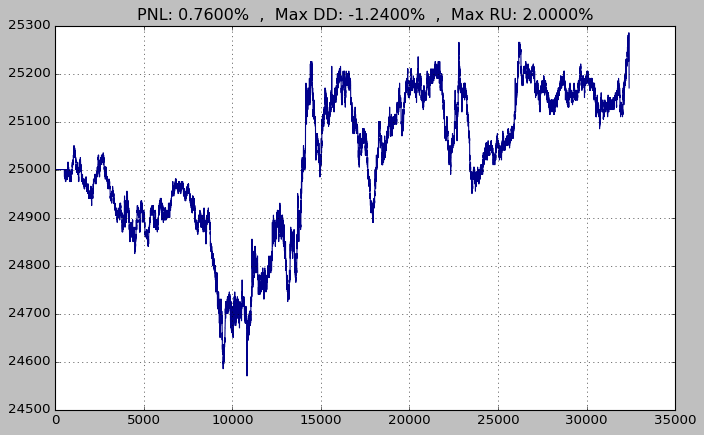

[run = 2] (2024-09-27 12:00:00, 2024-09-27 21:00:00) account_value: 25000 -> 24770


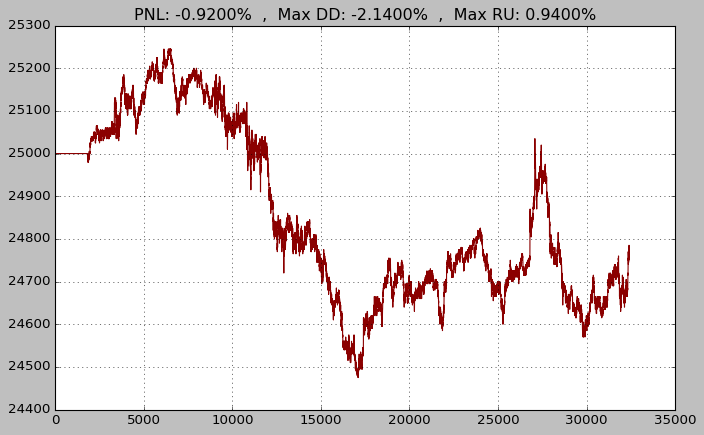

[run = 3] (2024-09-30 12:00:00, 2024-09-30 21:00:00) account_value: 25000 -> 25010


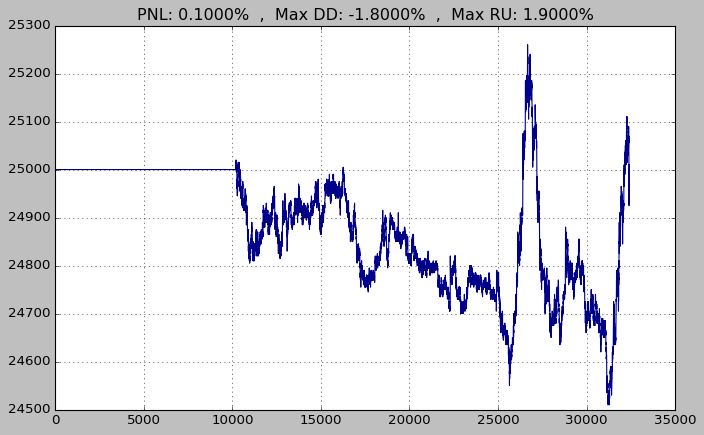

[run = 4] (2024-10-01 12:00:00, 2024-10-01 21:00:00) account_value: 25000 -> 25925


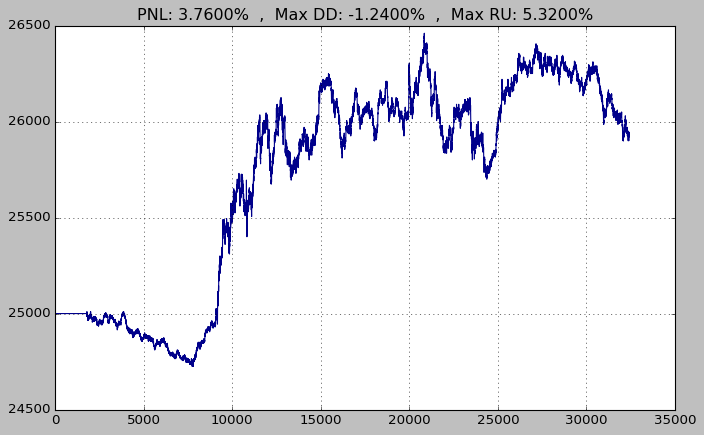

[run = 5] (2024-10-02 12:00:00, 2024-10-02 21:00:00) account_value: 25000 -> 24210


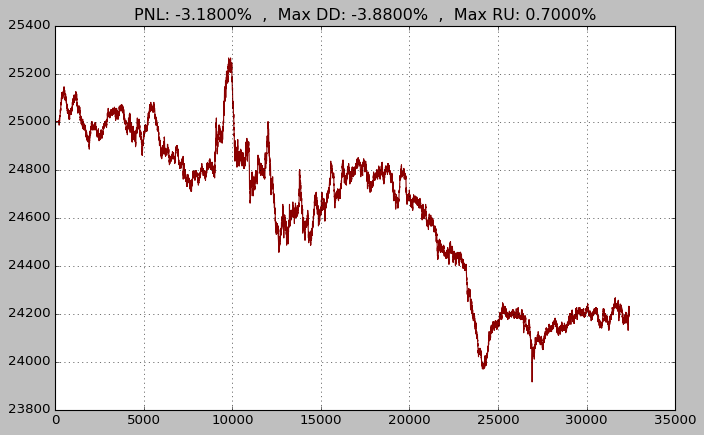

[run = 6] (2024-10-03 12:00:00, 2024-10-03 21:00:00) account_value: 25000 -> 23345


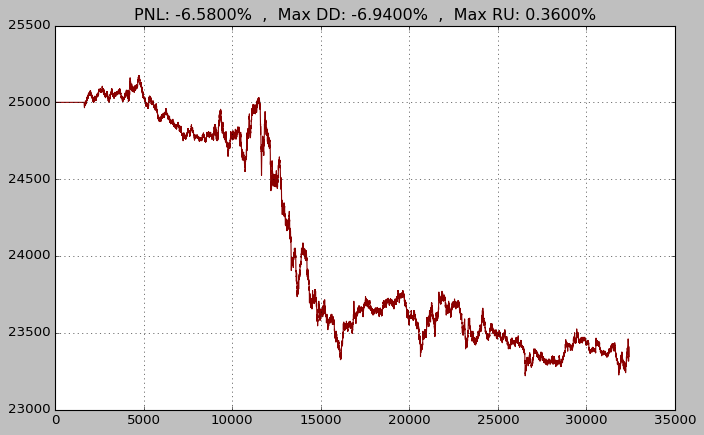

[run = 7] (2024-10-04 10:00:00, 2024-10-04 21:00:00) account_value: 25000 -> 25445


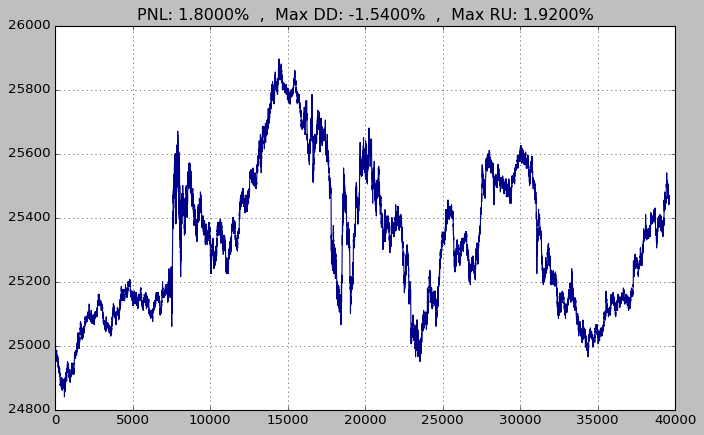

In [8]:
bt = make_bt()

returns = []
for idx, run in enumerate(bt.runs):
    start_account_value = run.vectors.account_value.value.iloc[0]
    end_account_value = (
        start_account_value
        if run.vectors.account_value.shape[0] == 0
        else run.vectors.account_value.value.iloc[-1]
    )
    print(f"[run = {idx}] ({run.range.start}, {run.range.end}) account_value: {start_account_value} -> {end_account_value}")
    
    pnl = run.trade_statistics.closed_trades_profit_loss[0]
    pnl_pct =  pnl / start_account_value
    returns.append(pnl)
    
    dd = run.trade_statistics.maximum_drawdown[0]
    dd_pct = dd / start_account_value
    
    ru = run.trade_statistics.maximum_runup[0]
    ru_pct = ru / start_account_value
    
    run.vectors.account_value.value.plot(
        title=f"PNL: {pnl_pct*100:.4f}%  ,  Max DD: {dd_pct*100:.4f}%  ,  Max RU: {ru_pct*100:.4f}%",
        color="darkblue" if pnl >= 0 else "darkred",
    )
    plt.show()

balance -> 23885


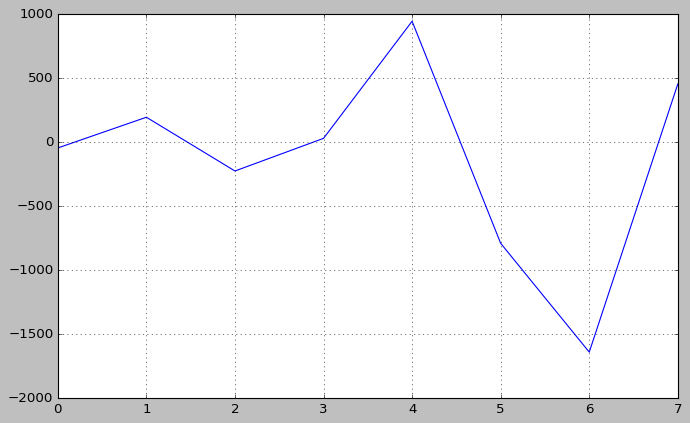

In [18]:
starting_balance = 25000
for r in returns:
    starting_balance += r
    
print(f'balance -> {starting_balance}')
plt.plot(returns)

In [19]:
ts = pd.concat([b.trade_statistics.T for b in bt.runs], axis=1)
ts.columns = list(range(len(bt.runs)))
ts

,0,1,2,3,4,5,6,7
closed_trades_profit_loss,-50,190,-230,25,940,-795,-1645,450
closed_trades_total_profit,190,655,350,505,1480,175,90,910
closed_trades_total_loss,-240,-465,-580,-480,-540,-970,-1735,-460
profit_factor,0.791667,1.4086,0.603448,1.05208,2.74074,0.180412,0.051873,1.97826
equity_peak,0,190,70,25,1100,0,0,450
equity_valley,-240,-310,-465,-450,790,-970,-1735,20
maximum_runup,190,500,235,475,1330,175,90,480
maximum_drawdown,-240,-310,-535,-450,-310,-970,-1735,-385
maximum_flat_to_flat_trade_open_profit,420,575,515,645,1485,500,400,970
maximum_flat_to_flat_trade_open_loss,-130,-225,-220,-145,-275,-195,-405,-355
